# Audio to spectrograms

In [ ]:
%pip install numpy pandas matplotlib librosa tensorflow ipython scikit-learn
%pip install --upgrade typing_extensions


In [13]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

import tensorflow as tf
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import ImageFile
from sklearn.metrics import f1_score
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Please have a look:
# https://www.kaggle.com/code/msripooja/steps-to-convert-audio-clip-to-spectrogram

In [2]:
audio_fpath = "D:\\daps\\cleanraw"
audio_clips = os.listdir(audio_fpath)
print("Number of .wav files in audio folder = ",len(audio_clips))

Number of .wav files in audio folder =  200


In [6]:
#image_path = "D:\\cleanraw_images_trimmed\\cleanraw_images_trimmed"
image_path = "D:\\cleanraw_images\\cleanraw_images"

In [32]:
# Ensure the directory exists
if not os.path.exists(image_path):
    os.makedirs(image_path)

# Segment length in seconds 
segment_length = 5
# I can start with 8 (but 3)

# Initialize variables to track global dB range
global_min_db = np.inf
global_max_db = -np.inf

# Compute global min/max dB across all files and segments
for i in range(len(audio_clips)):
    file_name = audio_clips[i]
    # print(f"Processing {file_name} for global dB range")

    # Load the audio
    x, sr = librosa.load(audio_fpath + file_name, sr=44100)

    # Calculate the number of samples per segment
    samples_per_segment = segment_length * sr
    total_samples = len(x)
    num_segments = int(np.ceil(total_samples / samples_per_segment))

    # Process each segment to find the min/max dB
    for segment in range(num_segments):
        start_sample = segment * samples_per_segment
        end_sample = min(start_sample + samples_per_segment, total_samples)
        x_segment = x[start_sample:end_sample]

        # Perform STFT on the segment
        X = librosa.stft(x_segment)
        Xdb = librosa.amplitude_to_db(abs(X))

        # Update global min/max dB
        global_min_db = min(global_min_db, Xdb.min())
        global_max_db = max(global_max_db, Xdb.max())

print(f"Global dB range: {global_min_db} to {global_max_db}")

Global dB range: -94.55022430419922 to 50.414695739746094


In [ ]:

if not os.path.exists(image_path):
    os.makedirs(image_path)
global_min_db = -40 # if it is smaller than 40 the images are too 

# Generate spectrograms with the same scale
for i in range(len(audio_clips)):
    file_name = audio_clips[i]
    print(f"Processing {file_name} for spectrograms")

    # Load the audio
    x, sr = librosa.load(audio_fpath + file_name, sr=44100)

    # Calculate the number of samples per segment
    samples_per_segment = segment_length * sr
    total_samples = len(x)
    num_segments = int(np.ceil(total_samples / samples_per_segment))

    # Process each segment
    for segment in range(num_segments):
        start_sample = segment * samples_per_segment
        end_sample = min(start_sample + samples_per_segment, total_samples)
        x_segment = x[start_sample:end_sample]

        # Perform STFT on the segment
        X = librosa.stft(x_segment)
        Xdb = librosa.amplitude_to_db(abs(X))

        # Create the plot for the spectrogram with consistent scale
        plt.figure(figsize=(14, 5), dpi=400)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', vmin=global_min_db, vmax=global_max_db, cmap='gray')
        plt.colorbar()

        # Save the figure for this segment
        segment_file_name = f"{file_name[:-4]}_segment_{segment+1}_spectrogram.png"
        plt.savefig(os.path.join(image_path, segment_file_name))
        plt.close()

print("Spectrograms for segments with consistent scale are saved.")

# from this point is not working

In [ ]:
global_min_db = -40
global_max_db = 51


# Ensure the directory exists
if not os.path.exists(image_path):
    os.makedirs(image_path)

# Segment length in seconds
segment_length = 5

# Silence threshold (adjust based on your data)
silence_threshold = 0.01  # RMS threshold for considering silence (you can adjust this)


# Generate spectrograms with the same scale, skipping silent segments
for i in range(len(audio_clips)):
    file_name = audio_clips[i]
    print(f"Processing {file_name} for spectrograms")

    # Load the audio
    x, sr = librosa.load(audio_fpath + file_name, sr=44100)

    # Calculate the number of samples per segment
    samples_per_segment = segment_length * sr
    total_samples = len(x)
    num_segments = int(np.ceil(total_samples / samples_per_segment))

    # Process each segment
    for segment in range(num_segments):
        start_sample = segment * samples_per_segment
        end_sample = min(start_sample + samples_per_segment, total_samples)
        x_segment = x[start_sample:end_sample]

        # Calculate RMS energy for the segment
        rms_energy = np.sqrt(np.mean(x_segment ** 2))

        # Skip silent segments
        if rms_energy < silence_threshold:
            print(f"Skipping segment {segment+1} of {file_name} due to low RMS energy ({rms_energy:.6f})")
            continue

        # Perform STFT on the non-silent segment
        X = librosa.stft(x_segment)
        Xdb = librosa.amplitude_to_db(abs(X))

        # Create the plot for the spectrogram with consistent scale
        plt.figure(figsize=(14, 5), dpi=400)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', vmin=global_min_db, vmax=global_max_db, cmap='gray')
        plt.colorbar()

        # Save the figure for this segment
        segment_file_name = f"{file_name[:-4]}_segment_{segment+1}_spectrogram.png"
        plt.savefig(os.path.join(image_path, segment_file_name))
        plt.close()

print("Spectrograms for non-silent segments with consistent scale are saved.")


Processing m2_script5_cleanraw.wav for spectrograms
Skipping segment 1 of m2_script5_cleanraw.wav due to low RMS energy (0.001648)
Skipping segment 32 of m2_script5_cleanraw.wav due to low RMS energy (0.001300)
Processing m2_script2_cleanraw.wav for spectrograms
Skipping segment 1 of m2_script2_cleanraw.wav due to low RMS energy (0.001541)
Processing f5_script2_cleanraw.wav for spectrograms
Skipping segment 1 of f5_script2_cleanraw.wav due to low RMS energy (0.002852)
Skipping segment 34 of f5_script2_cleanraw.wav due to low RMS energy (0.003212)
Processing f5_script5_cleanraw.wav for spectrograms
Skipping segment 1 of f5_script5_cleanraw.wav due to low RMS energy (0.002595)
Processing m7_script2_cleanraw.wav for spectrograms
Skipping segment 1 of m7_script2_cleanraw.wav due to low RMS energy (0.001160)
Processing m7_script5_cleanraw.wav for spectrograms
Skipping segment 1 of m7_script5_cleanraw.wav due to low RMS energy (0.001091)
Skipping segment 30 of m7_script5_cleanraw.wav due to 

In [ ]:
# Loop through all spectrograms in the folder
for img_file in os.listdir(image_path):
    if img_file.endswith(".png"):  # Only process PNG files (or adjust for your file format)
        image_file = os.path.join(image_path, img_file)
        
        # Load the spectrogram image in grayscale
        spectrogram_img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        
        if spectrogram_img is not None:
            # Normalize the pixel values to range [0, 1]
            spectrogram_img = spectrogram_img / 255.0

            # Calculate statistical features
            mean = np.mean(spectrogram_img)
            variance = np.var(spectrogram_img)
            entropy = -np.sum(spectrogram_img * np.log2(spectrogram_img + 1e-10))  # Shannon entropy

            # Print the calculated features for the current image
            print(f"Image: {img_file}, Mean: {mean:.4f}, Variance: {variance:.4f}, Entropy: {entropy:.4f}")
        else:
            print(f"Error: Could not load image {image_file}")


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Path to the audio and image directories
audio_fpath = "/Users/gosiakurcjusz/Downloads/daps/cleanraw/"
audio_clips = os.listdir(audio_fpath)
print("Number of .wav files in audio folder = ", len(audio_clips))



# Ensure the directory exists
if not os.path.exists(image_path):
    os.makedirs(image_path)

# Segment length in seconds
segment_length = 5

# Global dB range for consistent scaling
global_min_db = -40
global_max_db = 51

# Silence trimming threshold (adjust based on your data)
trim_db_threshold = 30  # The lower the value, the more aggressively silence is removed

# Generate spectrograms from audio with trimmed silence
for i in range(len(audio_clips)):
    file_name = audio_clips[i]
    print(f"Processing {file_name} to remove silence and generate spectrograms")

    # Load the audio
    x, sr = librosa.load(audio_fpath + file_name, sr=44100)

    # Trim the silence from the audio based on a decibel threshold
    x_trimmed, _ = librosa.effects.trim(x, top_db=trim_db_threshold)

    print(f"Original length: {len(x)} samples, Trimmed length: {len(x_trimmed)} samples")

    # Calculate the number of samples per segment in the trimmed audio
    samples_per_segment = segment_length * sr
    total_samples = len(x_trimmed)
    num_segments = int(np.ceil(total_samples / samples_per_segment))

    # Process each segment in the trimmed audio
    for segment in range(num_segments):
        start_sample = segment * samples_per_segment
        end_sample = min(start_sample + samples_per_segment, total_samples)
        x_segment = x_trimmed[start_sample:end_sample]

        # Perform STFT on the segment
        X = librosa.stft(x_segment)
        Xdb = librosa.amplitude_to_db(abs(X))

        # Create the plot for the spectrogram with consistent scale
        plt.figure(figsize=(14, 5), dpi=400)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', vmin=global_min_db, vmax=global_max_db, cmap='gray')
        plt.colorbar()

        # Save the figure for this segment
        segment_file_name = f"{file_name[:-4]}_segment_{segment+1}_spectrogram_trimmed.png"
        plt.savefig(os.path.join(image_path, segment_file_name))
        plt.close()

print("Spectrograms for trimmed audio segments with consistent scale are saved.")


Number of .wav files in audio folder =  100
Processing m2_script5_cleanraw.wav to remove silence and generate spectrograms
Original length: 6836905 samples, Trimmed length: 6478848 samples
Processing m2_script2_cleanraw.wav to remove silence and generate spectrograms
Original length: 8265504 samples, Trimmed length: 7931904 samples
Processing f5_script2_cleanraw.wav to remove silence and generate spectrograms
Original length: 7292494 samples, Trimmed length: 6969344 samples
Processing f5_script5_cleanraw.wav to remove silence and generate spectrograms
Original length: 6153659 samples, Trimmed length: 5804032 samples
Processing m7_script2_cleanraw.wav to remove silence and generate spectrograms
Original length: 7404224 samples, Trimmed length: 7045120 samples
Processing m7_script5_cleanraw.wav to remove silence and generate spectrograms
Original length: 6450430 samples, Trimmed length: 6119424 samples
Processing m8_script2_cleanraw.wav to remove silence and generate spectrograms
Origina

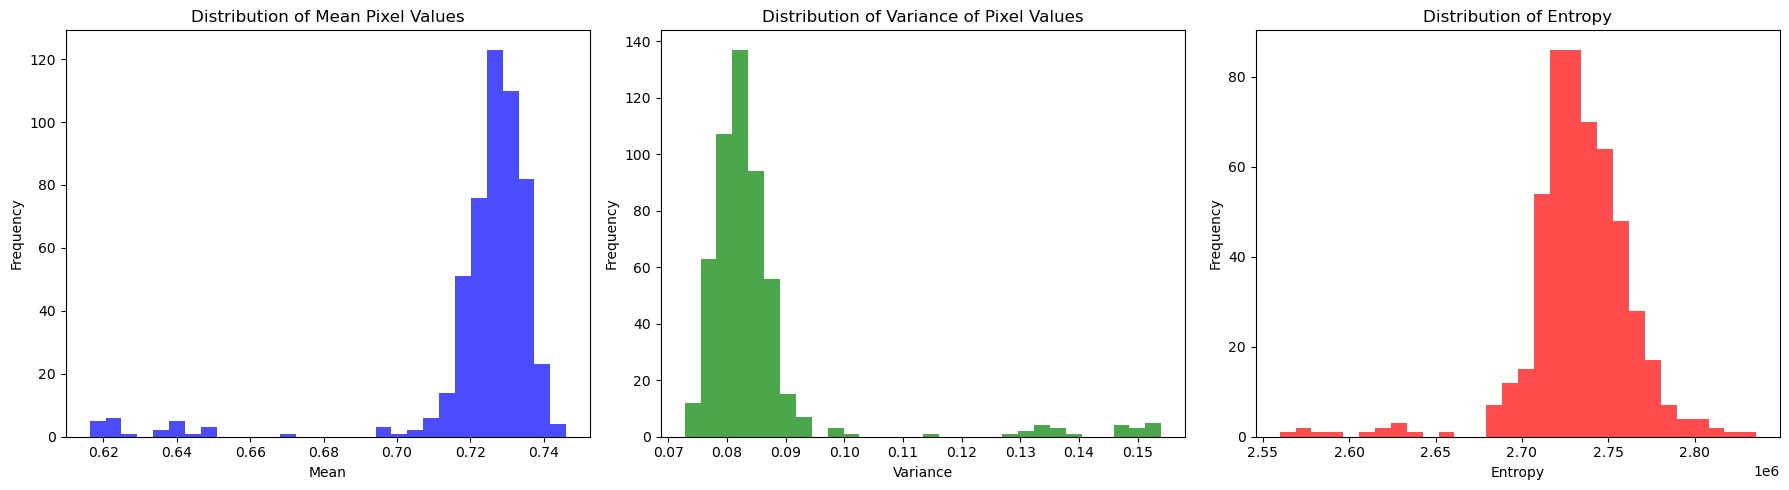

In [8]:

# Lists to store the features for all images
means = []
variances = []
entropies = []

# Loop through all spectrograms in the folder
for img_file in os.listdir(image_path):
    if img_file.endswith(".png"):  # Only process PNG files
        image_file = os.path.join(image_path, img_file)
        
        # Load the spectrogram image in grayscale
        spectrogram_img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        
        if spectrogram_img is not None:
            # Normalize the pixel values to range [0, 1]
            spectrogram_img = spectrogram_img / 255.0

            # Calculate statistical features
            mean = np.mean(spectrogram_img)
            variance = np.var(spectrogram_img)
            entropy = -np.sum(spectrogram_img * np.log2(spectrogram_img + 1e-10))  # Shannon entropy

            # Store the features in the respective lists
            means.append(mean)
            variances.append(variance)
            entropies.append(entropy)

# After the loop, generate plots

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Mean
axes[0].hist(means, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Distribution of Mean Pixel Values')
axes[0].set_xlabel('Mean')
axes[0].set_ylabel('Frequency')

# Plot Variance
axes[1].hist(variances, bins=30, color='green', alpha=0.7)
axes[1].set_title('Distribution of Variance of Pixel Values')
axes[1].set_xlabel('Variance')
axes[1].set_ylabel('Frequency')

# Plot Entropy
axes[2].hist(entropies, bins=30, color='red', alpha=0.7)
axes[2].set_title('Distribution of Entropy')
axes[2].set_xlabel('Entropy')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


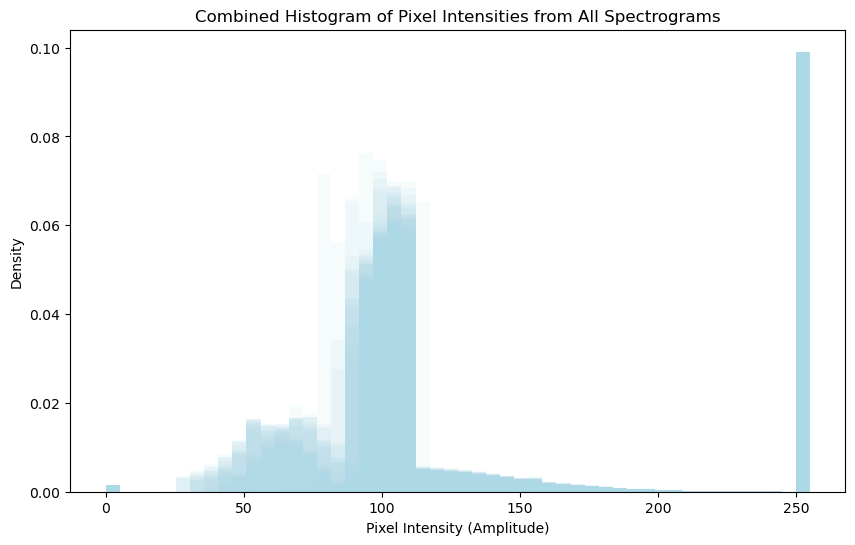

In [13]:
# pair of histograms mean of class 1 and mean of class 0 next to each other
# noise analysis with the goal -> what happens with classes (use the ready model for that)
# plot classes f1 - green
# f7 - green histograms
# f8... - separate histograms for each speaker, histograms green for class 1
# for class 0 - blue separate for each speaker
# how the properties change after I remove silence
# how the length changes after removal the silence
# for each speaker how many 5 seconds before and after silence removal
# I should: 
# 1) remove the silence from the audio, 
# 2) then I should cut it into 3-8 seconds (let's choose some) spectrograms 
# 3) I should show how it changes before and after with the length/number of spectrograms for each person
# 4) I should create histograms before removing the noise
# 4i) mean of class 1 and mean of class 0 next to each other
# 4ii) separate histograms for each speaker, histograms green for class 1, histograms blue for class 0
# 4iii)
# 5) I should create histograms after removing the noise: the same and compare them

# Initialize a figure for the combined histogram
plt.figure(figsize=(10, 6))

# Loop through all spectrograms in the folder
for img_file in os.listdir(image_path):
    if img_file.endswith(".png"):  # Only process PNG files
        image_file = os.path.join(image_path, img_file)
        
        # Load the spectrogram image in grayscale
        spectrogram_img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        
        if spectrogram_img is not None:
            # Flatten the 2D spectrogram to 1D
            spectrogram_flat = spectrogram_img.flatten()

            # Plot histogram of pixel intensities with light blue color and transparency
            plt.hist(spectrogram_flat, bins=50, alpha=0.1, color='lightblue', density=True)

# Add titles and labels
plt.title('Combined Histogram of Pixel Intensities from All Spectrograms')
plt.xlabel('Pixel Intensity (Amplitude)')
plt.ylabel('Density')

# Show the plot
plt.show()


In [12]:
# we need to classify for class 0 and class 1
# we need to divide 70, 20, 10 with validation test

In [7]:
spectrograms = os.listdir(image_path)

class_1_prefixes = {'f1_', 'f7_', 'f8_', 'm3_', 'm6_', 'm8_'}
file_labels = []

for i in range(len(spectrograms)):
    
    file_name = spectrograms[i]
    # Extract the first two characters to determine the class
    prefix = file_name[:3]
    
    # Assign class based on the prefix
    if prefix in class_1_prefixes:
        label = 1
    else:
        label = 0
    
    # Append the file name and label to the list
    file_labels.append([file_name, label])

    print(f"Processing file: {file_name}, Classified as: {label}")


Processing file: f10_script1_cleanraw_spectrogram.png, Classified as: 0
Processing file: f1_script1_cleanraw_spectrogram.png, Classified as: 1
Processing file: f1_script2_cleanraw_spectrogram.png, Classified as: 1
Processing file: f1_script3_cleanraw_spectrogram.png, Classified as: 1
Processing file: f1_script4_cleanraw_spectrogram.png, Classified as: 1
Processing file: f1_script5_cleanraw_spectrogram.png, Classified as: 1
Processing file: f2_script1_cleanraw_spectrogram.png, Classified as: 0
Processing file: f2_script2_cleanraw_spectrogram.png, Classified as: 0
Processing file: f2_script3_cleanraw_spectrogram.png, Classified as: 0
Processing file: f2_script4_cleanraw_spectrogram.png, Classified as: 0
Processing file: f2_script5_cleanraw_spectrogram.png, Classified as: 0
Processing file: f3_script1_cleanraw_spectrogram.png, Classified as: 0
Processing file: f4_script1_cleanraw_spectrogram.png, Classified as: 0
Processing file: f4_script2_cleanraw_spectrogram.png, Classified as: 0
Proce

In [8]:
# Create a DataFrame to store file names and labels
df = pd.DataFrame(file_labels, columns=['file_name', 'label'])

# Save the labels to a CSV file
# df.to_csv('file_labels.csv', index=False)
csv_path = os.path.join(image_path, '_file_labels.csv')
df.to_csv(csv_path, index=False)


print("Spectrograms are saved and labels are stored in _file_labels.csv.")

Spectrograms are saved and labels are stored in _file_labels.csv.


In [9]:
# Load the CSV file with file names and labels
df = pd.read_csv(csv_path)

# Ensure the filenames have the correct full path (if needed)
df['file_name'] = df['file_name'].apply(lambda x: os.path.join(image_path, x))

# Split the dataset into 80% train+validation and 20% test
train_val, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Now split the 80% (train+validation) into 70% training and 10% validation
train, val = train_test_split(train_val, test_size=0.125, random_state=42, stratify=train_val['label'])

# Output sizes of each split to verify
print(f"Training set: {len(train)} samples")
print(f"Validation set: {len(val)} samples")
print(f"Test set: {len(test)} samples")

# Save the splits to CSV files if needed
train.to_csv(os.path.join(image_path, 'train_set.csv'), index=False)
val.to_csv(os.path.join(image_path, 'val_set.csv'), index=False)
test.to_csv(os.path.join(image_path, 'test_set.csv'), index=False)

print("Datasets are split and saved in the folder:", image_path)

Training set: 52 samples
Validation set: 8 samples
Test set: 16 samples
Datasets are split and saved in the folder: D:\cleanraw_images\cleanraw_images


In [8]:
print(audio_clips[1][:2])

._


In [9]:
class SafeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator):
        self.base_generator = base_generator

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, index):
        while True:
            try:
                # Attempt to retrieve the batch from the base generator
                return self.base_generator[index]
            except (OSError, IOError) as e:
                print(f"Skipping corrupted image at index {index}. Error: {e}")
                # Return an empty batch or move to the next index
                index = (index + 1) % len(self.base_generator)

# Wrap your train and validation generators with SafeDataGenerator
train_generator_safe = SafeDataGenerator(train_generator)
val_generator_safe = SafeDataGenerator(val_generator)


NameError: name 'train_generator' is not defined

In [11]:
train_csv = os.path.join(image_path, 'train_set.csv')
val_csv = os.path.join(image_path, 'val_set.csv')
test_csv = os.path.join(image_path, 'test_set.csv')

# Load the CSV files
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Convert the 'label' column to strings (required for binary classification in Keras)
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# ImageDataGenerator to load images and apply basic augmentation (rescale)
datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_name',  # Path to the image
    y_col='label',      # Class label (0 or 1)
    target_size=(500, 500),  # Resize images
    batch_size=16,
    class_mode='binary', # Binary classification (class 0 or 1)
    error_on_missing=False
)

# Load the validation data
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_name',
    y_col='label',
    target_size=(500, 500),
    batch_size=16,
    class_mode='binary',
    error_on_missing=False
)

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

# Evaluate the model on the test set
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_name',
    y_col='label',
    target_size=(500, 500),
    batch_size=1,
    class_mode='binary',
    error_on_missing=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
y_pred = np.round(predictions).astype(int)

# Extract the true labels from the test generator
y_true = test_df['label'].astype(int).values

# Ensure the length of predictions matches the length of true labels
assert len(y_pred) == len(y_true)

# Calculate macro-averaged F1-score
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Macro-Averaged F1-Score: {f1_macro}")

Found 52 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
Epoch 1/50
4/4 [==============================] - 11s 2s/step - loss: 19.1284 - accuracy: 0.4231 - val_loss: 4.5372 - val_accuracy: 0.3750
Epoch 2/50
4/4 [==============================] - 10s 2s/step - loss: 2.1552 - accuracy: 0.5769 - val_loss: 0.8132 - val_accuracy: 0.6250
Epoch 3/50
4/4 [==============================] - 10s 2s/step - loss: 0.8098 - accuracy: 0.4615 - val_loss: 0.6665 - val_accuracy: 0.6250
Epoch 4/50
4/4 [==============================] - 10s 2s/step - loss: 0.6895 - accuracy: 0.6154 - val_loss: 0.7261 - val_accuracy: 0.6250
Epoch 5/50
4/4 [==============================] - 10s 3s/step - loss: 0.7021 - accuracy: 0.6154 - val_loss: 0.6618 - val_accuracy: 0.6250
Epoch 6/50
4/4 [==============================] - 12s 3s/step - loss: 0.7029 - accuracy: 0.3846 - val_loss: 0.6878 - val_accuracy: 0.6250
Epoch 7/50
4/4 [==============================] - 11s 

In [14]:
def load_spectrogram_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array


In [ ]:
# Example: X contains spectrogram images, y contains labels
X = np.array([load_spectrogram_image(f) for f in image_path])
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Adjust for the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

classifier v2


Found 52 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Epoch 1/50
2/2 [==============================] - 10s 4s/step - loss: 14.9737 - accuracy: 0.3846 - val_loss: 5.5276 - val_accuracy: 0.6250
Epoch 2/50
2/2 [==============================] - 9s 4s/step - loss: 4.5654 - accuracy: 0.5385 - val_loss: 1.0321 - val_accuracy: 0.3750
Epoch 3/50
2/2 [==============================] - 9s 4s/step - loss: 0.8784 - accuracy: 0.3846 - val_loss: 0.6760 - val_accuracy: 0.6250
Epoch 4/50
2/2 [==============================] - 9s 4s/step - loss: 0.6748 - accuracy: 0.6154 - val_loss: 0.6555 - val_accuracy: 0.6250
Epoch 5/50
2/2 [==============================] - 10s 4s/step - loss: 0.6538 - accuracy: 0.6154 - val_loss: 0.7761 - val_accuracy: 0.3750
Epoch 6/50
2/2 [==============================] - 10s 4s/step - loss: 0.8018 - accuracy: 0.3846 - val_loss: 0.6788 - val_accuracy: 0.625

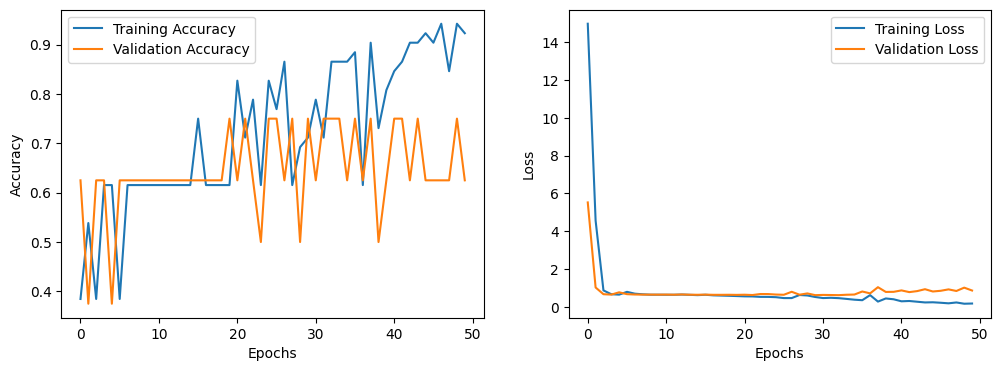

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the CSV files with the train, validation, and test splits
train_df = pd.read_csv(os.path.join(image_path, 'train_set.csv'))
val_df = pd.read_csv(os.path.join(image_path, 'val_set.csv'))
test_df = pd.read_csv(os.path.join(image_path, 'test_set.csv'))

# Image dimensions
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 32


# Data generators for loading the images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Convert label column to string type for compatibility with binary class mode
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Data generators for loading the images
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs without improvement before stopping
    restore_best_weights=True # Restore the model weights from the epoch with the best value
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=50
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict the labels for the test set
y_pred_probs = model.predict(test_generator)

# Convert y_pred to strings to match y_true
y_pred = (y_pred_probs > 0.5).astype(int).astype(str).ravel()

# Get the true labels (they are already strings)
y_true = test_df['label'].values

# Calculate F1 score
f1 = f1_score(y_true, y_pred, pos_label='1', average='binary')
print(f'F1 Score: {f1:.2f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()